Importing dependencies

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import string
from collections import Counter
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk import pos_tag, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [10]:
df = pd.read_csv('IMDB Dataset.csv', quoting=3, on_bad_lines='skip')


In [12]:
def customFilter(text):
    text = str(text)  # 👈 Force convert to string
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = text.lower()  # lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove digits
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text


df['cleaned_text'] = df['review'].apply(customFilter)

TF-IDF based custom stop words

In [13]:
corpus = df['cleaned_text'].tolist()

In [14]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(corpus)
features = vectorizer.get_feature_names_out()
idf_scores = vectorizer.idf_

In [15]:
tfidf_df = pd.DataFrame({'word': features, 'idf': idf_scores})

In [16]:
low_idf_words = tfidf_df[tfidf_df['idf'] < 2.0]['word'].tolist()

In [17]:
# Merging with basic English stopwords
basic_stopwords = set(stopwords.words('english'))
CustomStopwords = basic_stopwords.union(set(low_idf_words))

In [18]:
with open('custom_stopwords.txt', 'w') as f:
    for word in sorted(CustomStopwords):
        f.write(word + '\n')

print(f"✅ Saved {len(CustomStopwords)} stopwords to 'custom_stopwords.txt'")

✅ Saved 199 stopwords to 'custom_stopwords.txt'


Removing the custom stop words now

In [19]:
with open('custom_stopwords.txt', 'r') as f:
    loaded_custom_stopwords = set(f.read().splitlines())





In [20]:
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered = [word for word in tokens if word not in loaded_custom_stopwords]
    return ' '.join(filtered)

In [21]:
df['no_stopwords'] = df['cleaned_text'].apply(remove_stopwords)

In [22]:
df_porter = df.copy()
df_snowball = df.copy()
df_wordNet = df.copy()

In [23]:
porter = PorterStemmer()

def porter_stemming(text):
    tokens = word_tokenize(text)
    stemmed = [porter.stem(word) for word in tokens]
    return ' '.join(stemmed)

df_porter['stemmed_text'] = df_porter['no_stopwords'].apply(porter_stemming)

In [24]:
snowball = SnowballStemmer('english')

def snowball_stemming(text):
    tokens = word_tokenize(text)
    stemmed = [snowball.stem(word) for word in tokens]
    return ' '.join(stemmed)

df_snowball['stemmed_text'] = df_snowball['no_stopwords'].apply(snowball_stemming)

In [25]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default noun

def lemmatize_text(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged]
    return ' '.join(lemmatized)

df_wordNet['lemmatized_text'] = df_wordNet['no_stopwords'].apply(lemmatize_text)

In [26]:
def get_vocab_size(text_series):
    words = ' '.join(text_series).split()
    return len(set(words))

print("Original (no_stopwords) vocab size:", get_vocab_size(df['no_stopwords']))
print("Porter stemmed vocab size:", get_vocab_size(df_porter['stemmed_text']))
print("Snowball stemmed vocab size:", get_vocab_size(df_snowball['stemmed_text']))
print("Lemmatized vocab size:", get_vocab_size(df_wordNet['lemmatized_text']))

Original (no_stopwords) vocab size: 1535
Porter stemmed vocab size: 1370
Snowball stemmed vocab size: 1359
Lemmatized vocab size: 1394


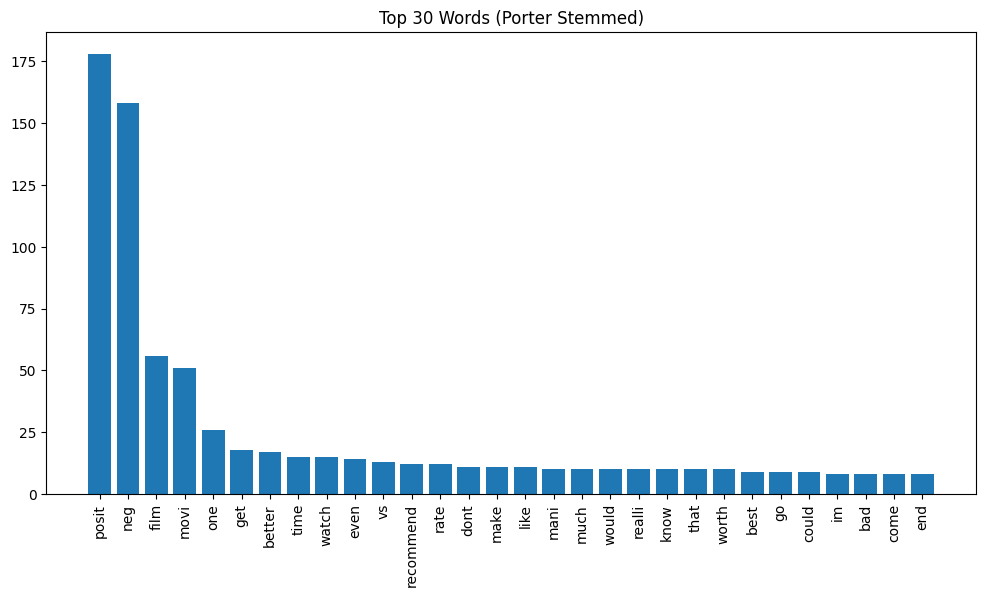

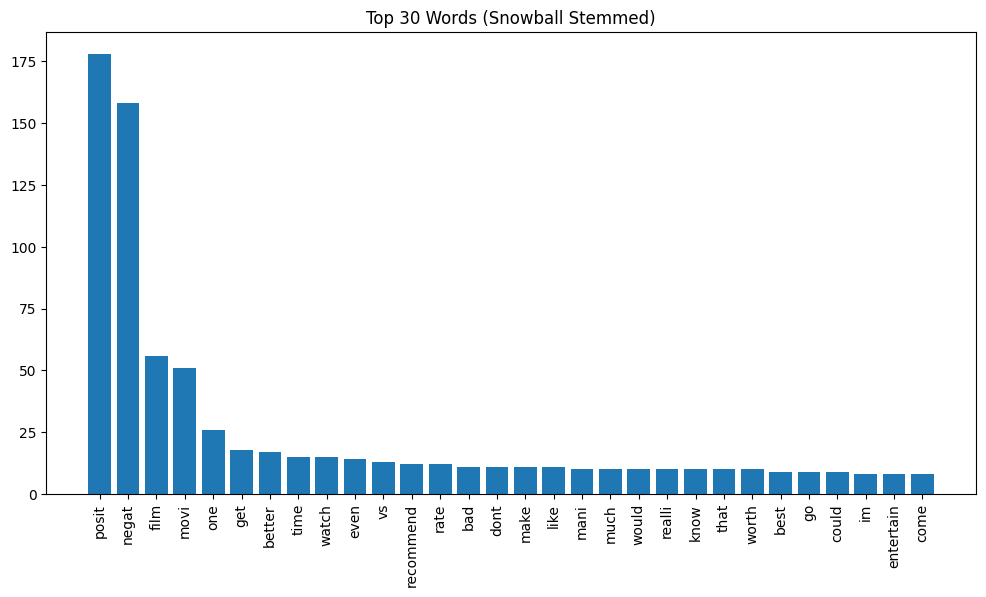

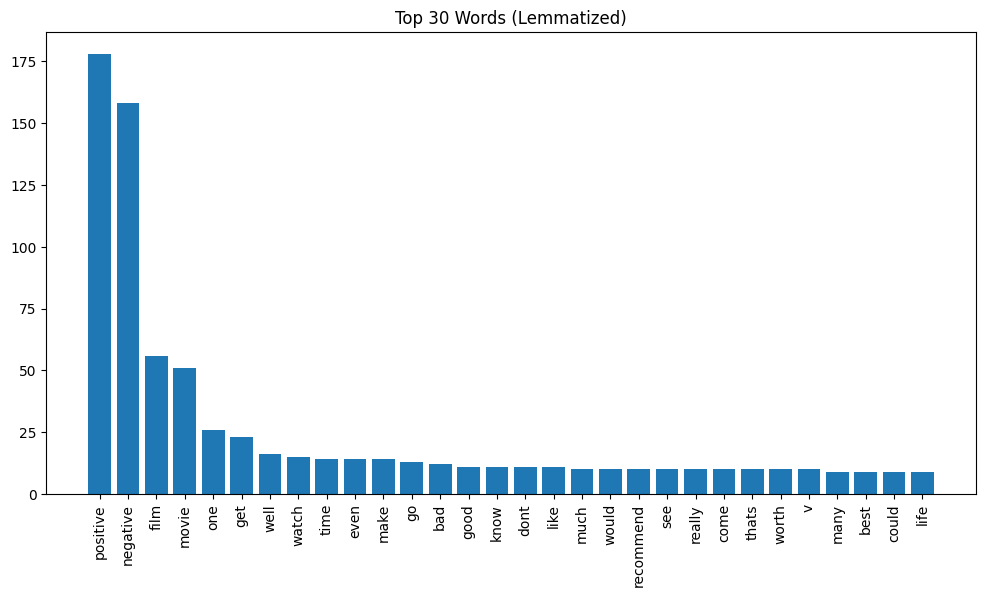

In [27]:
def plot_top_words(text_series, title):
    words = ' '.join(text_series).split()
    freq = Counter(words)
    common = freq.most_common(30)
    words, counts = zip(*common)
    plt.figure(figsize=(12, 6))
    plt.bar(words, counts)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

plot_top_words(df_porter['stemmed_text'], "Top 30 Words (Porter Stemmed)")
plot_top_words(df_snowball['stemmed_text'], "Top 30 Words (Snowball Stemmed)")
plot_top_words(df_wordNet['lemmatized_text'], "Top 30 Words (Lemmatized)")

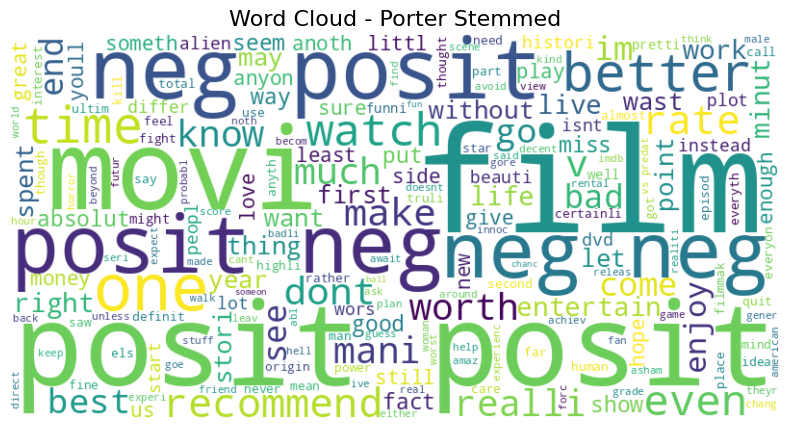

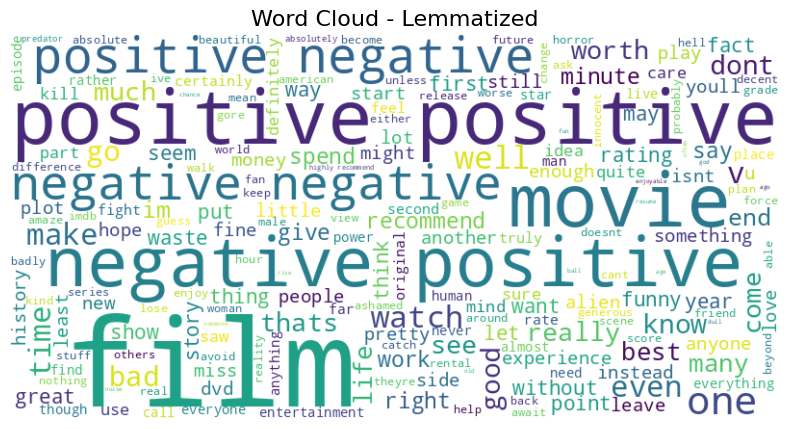

In [28]:
def generate_wordcloud(text_series, title):
    text = ' '.join(text_series)
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

generate_wordcloud(df_porter['stemmed_text'], "Word Cloud - Porter Stemmed")
generate_wordcloud(df_wordNet['lemmatized_text'], "Word Cloud - Lemmatized")

Vocab size :-

1)  Original (no_stopwords) vocab size: 1535
2)  Porter stemmed vocab size: 1370
3)  Snowball stemmed vocab size: 1359
4)  Lemmatized vocab size: 1394

My inference :-

1)  Stemming (both Porter and Snowball) reduced the vocabulary size by removing word suffixes. This merged many different forms of words into a single stem (e.g., "running", "runner", "runs" all becoming "run"), leading to a smaller, compressed vocabulary.

2)  Lemmatization has a bit bigger vocabulary size. It converted words into their correct base form while retaining grammatical meaning (e.g., "running" → "run", "better" → "good").

3)  Stemming sometimes distorted words into forms that are not real dictionary words, reducing the meaning of the text. Thus, although vocabulary shrinks, some semantic information is lost.

4)  Lemmatization, being context-aware and grammar-based, maintained proper words and meanings, leading to better preservation of the original sentence semantics.
I now have used TF-IDF approach to generate custom stop words and the custom stopword file is also being shared . 


Difference between Stemming and Lemmatization 

1)  simply removes the prefixes and/or suffixes from the words , whereas lemmatization takes care of vocabulary (grammatically)
2)  Stemming may not provide real words eg History -> histori , but lemmatization gives real words as the root word 
3)  Stemming is faster to do , lemmatization takes some time as it also takes care of POS tags inside the Corpus 
4)  Stemming reduces vocabulary size more aggressively, but it also merges different words incorrectly
5)  Lemmatization preserves more unique words, keeping grammatical meaning intact

Improvement in custom words list :-

Using TF_IDF approach to find out and handle low value words ...... rather than commonly occuring words like "movie" , "film" .
